In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv('data.csv')

Combine Date and Time columns into a single datetime column

In [3]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing 'kWh' suffix

In [4]:
df['Energy'] = df['Energy'].str.replace('kWh', '').astype(float)

In [5]:
df.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [6]:
df.sort_index(inplace=True)

In [7]:
df = df.resample('30min').last()

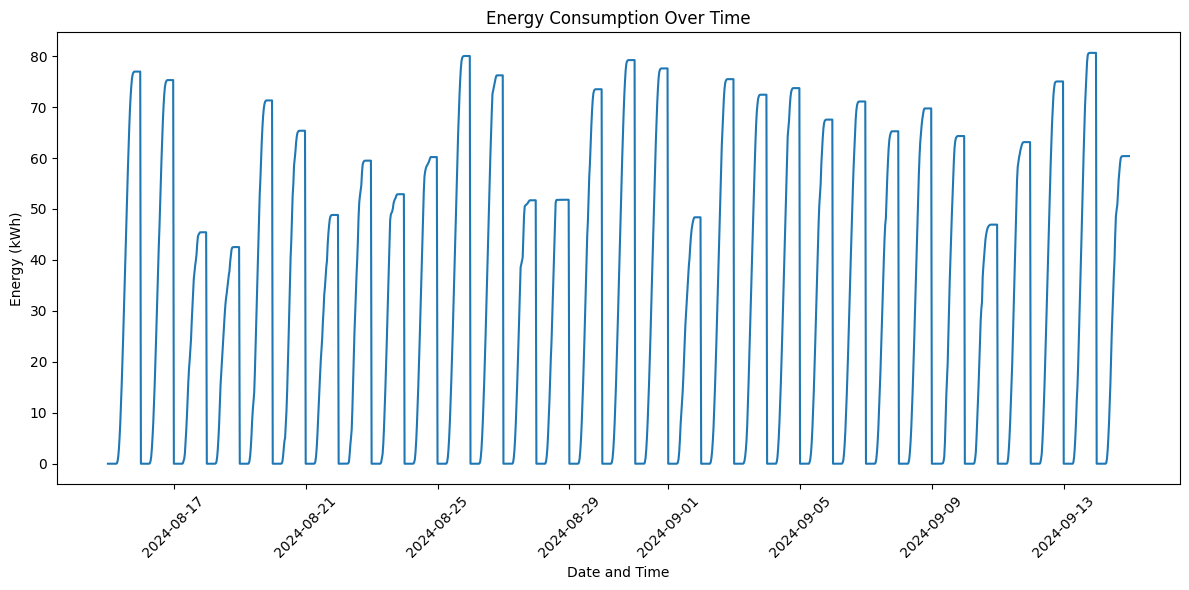

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.470848e+01
p-value                        2.872302e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.464000e+03
Critical Value (1%)           -3.434825e+00
Critical Value (5%)           -2.863516e+00
Critical Value (10%)          -2.567822e+00
dtype: float64


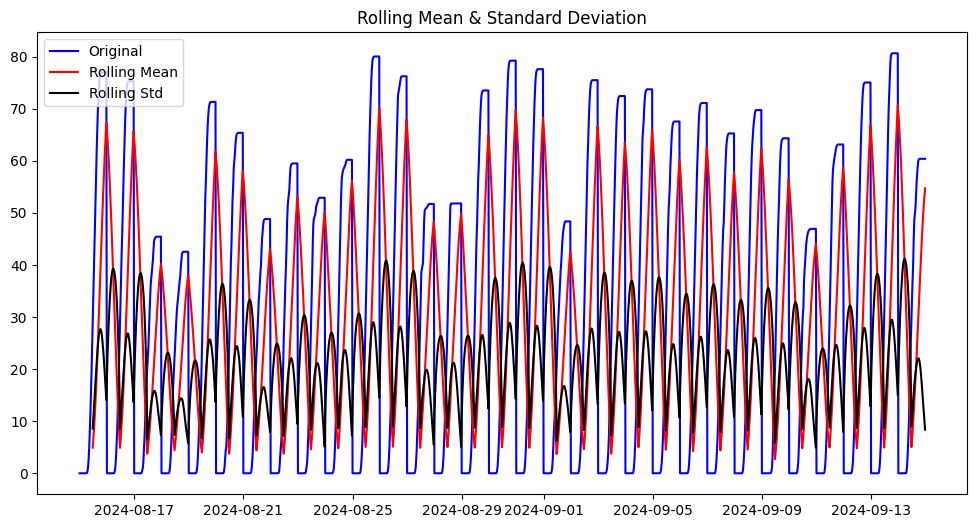

In [ ]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Plot rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    plt.figure(figsize=(12,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Check stationarity
check_stationarity(df['Energy'])


The test statistic (-14.71) is much lower (more negative) than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value (2.87e-27) is significantly smaller than 0.05, meaning we reject the null hypothesis of non-stationarity. Therefore, the data are considered stationary.

In [8]:
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter

In [ ]:
df.head()

,Date,Time,Energy,minute,hour,day,month,dayofweek,quarter
DateTime,,,,,,,,,
2024-08-15 00:00:00,15/08/2024,12:25AM,0.0,0,0,15,8,3,3
2024-08-15 00:30:00,15/08/2024,12:55AM,0.0,30,0,15,8,3,3
2024-08-15 01:00:00,15/08/2024,1:25AM,0.0,0,1,15,8,3,3
2024-08-15 01:30:00,15/08/2024,1:55AM,0.0,30,1,15,8,3,3
2024-08-15 02:00:00,15/08/2024,2:25AM,0.0,0,2,15,8,3,3


Split the data into training and testing sets (80% train, 20% test)

In [9]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [10]:
features = ['minute','hour', 'day', 'month', 'dayofweek', 'quarter']
X_train = train[features]
y_train = train['Energy']
X_test = test[features]
y_test = test['Energy']

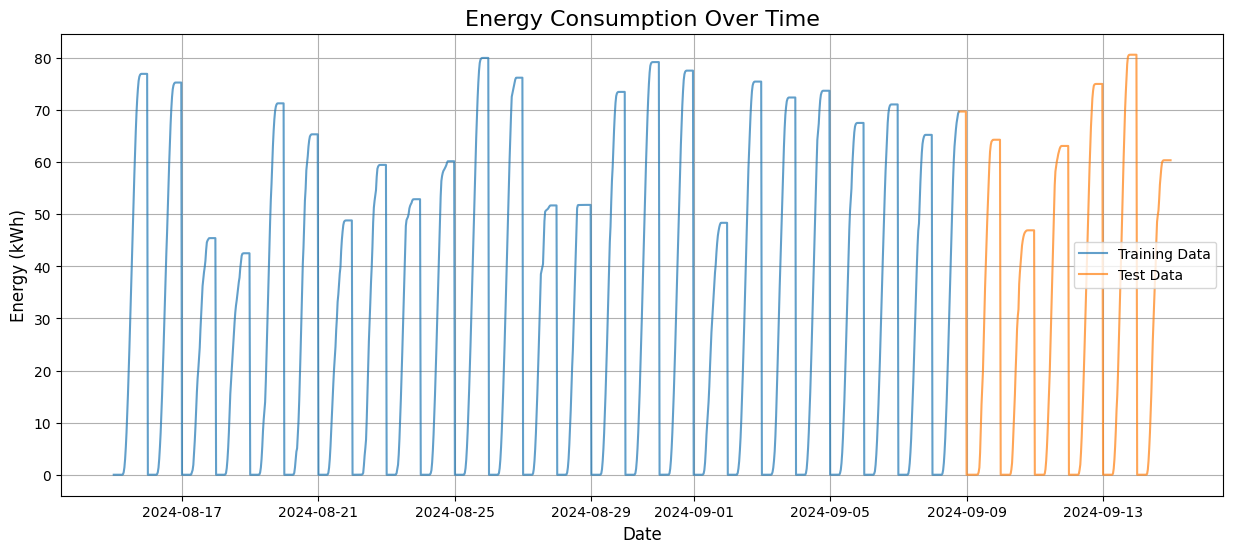

In [ ]:
def plot_feature_distributions(train, test, features):
    n_features = len(features)
    fig, axs = plt.subplots(n_features, 2, figsize=(15, 4*n_features))
    fig.suptitle('Feature Distributions in Training and Test Sets', fontsize=16)

    for i, feature in enumerate(features):
        sns.histplot(train[feature], kde=True, ax=axs[i, 0], color='blue', alpha=0.6)
        sns.histplot(test[feature], kde=True, ax=axs[i, 0], color='red', alpha=0.6)
        axs[i, 0].set_title(f'{feature} Distribution')
        axs[i, 0].legend(['Train', 'Test'])

        sns.boxplot(x=train[feature], ax=axs[i, 1], color='blue', width=0.4, positions=[0])
        sns.boxplot(x=test[feature], ax=axs[i, 1], color='red', width=0.4, positions=[1])
        axs[i, 1].set_title(f'{feature} Boxplot')
        axs[i, 1].set_xticklabels(['Train', 'Test'])

    plt.tight_layout()
    plt.show()

# Plot target variable
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['Energy'], label='Training Data', alpha=0.7)
plt.plot(test.index, test['Energy'], label='Test Data', alpha=0.7)
plt.title('Energy Consumption Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

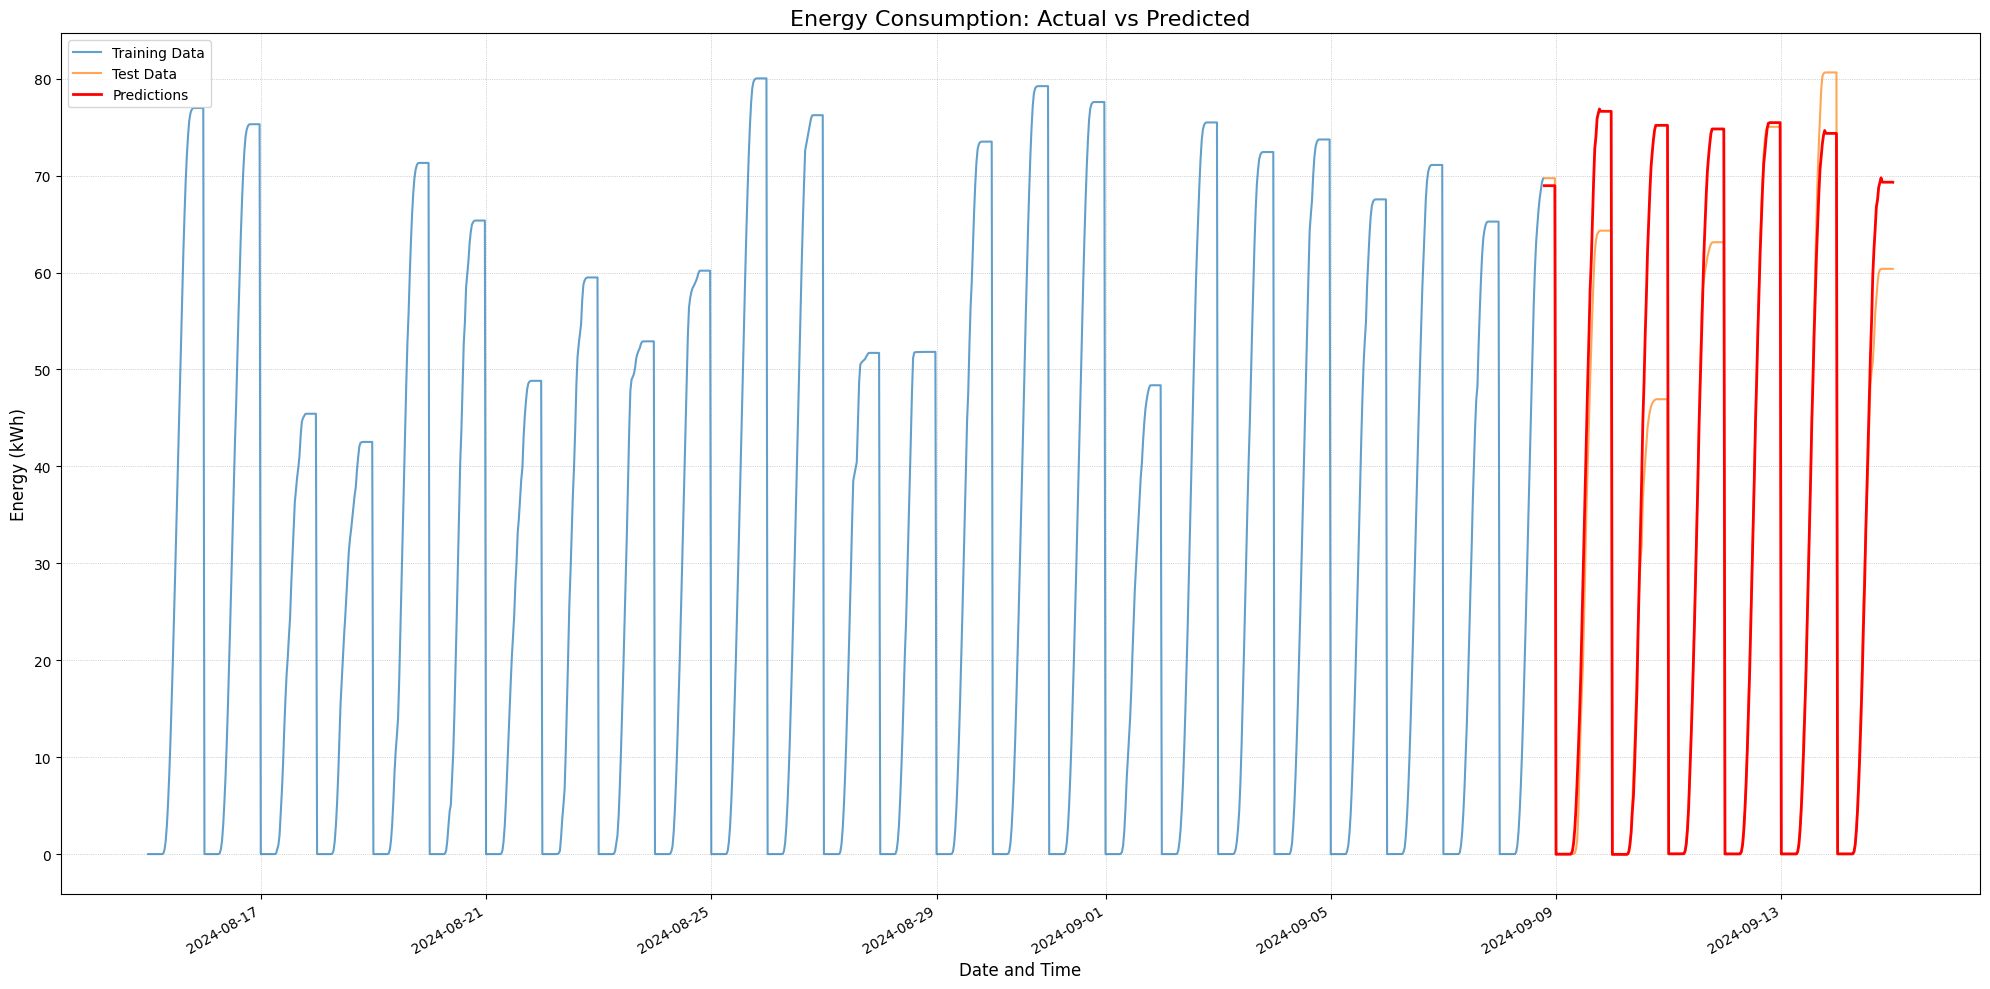

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train.index, train['Energy'], label='Training Data', alpha=0.7)
plt.plot(test.index, test['Energy'], label='Test Data', alpha=0.7)
plt.plot(test.index, test_predictions, label='Predictions', color='red', linewidth=2)
plt.title('Energy Consumption: Actual vs Predicted', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [13]:
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))


print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"Root Mean Square Error: {rmse:.2f} kWh")

Mean Absolute Error: 4.66 kWh
Root Mean Square Error: 8.38 kWh


Feature: minute, Score: 0.004192355088889599
Feature: hour, Score: 0.9254453778266907
Feature: day, Score: 0.035750195384025574
Feature: month, Score: 0.0
Feature: dayofweek, Score: 0.03461204096674919
Feature: quarter, Score: 0.0


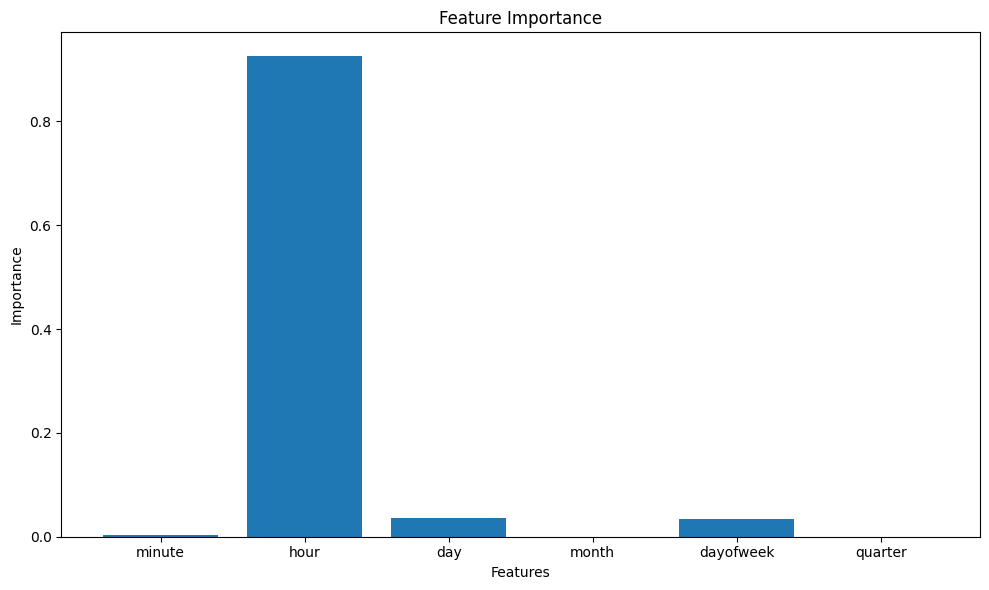

In [ ]:
# Feature importance
importance = model.feature_importances_
for i, v in enumerate(importance):
    print(f'Feature: {features[i]}, Score: {v}')

plt.figure(figsize=(10, 6))
plt.bar([x for x in features], importance)
plt.title("Feature Importance")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()